In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
os.remove("/kaggle/working/file_name.csv")

In [ ]:
!pip install gdown
!pip install tednet
!pip install pandas_ta
!pip install gym==0.15.7
!pip install numpy==1.23.5

In [ ]:
import gdown 

symbols = ['ADA', 'ETH','LTC','BNB','SOL', 'MATIC']
urls = ['1CBkBGvCssNqx_93R0vW2UUJDtJBllvI7',
       '1-8PQXoYjZKkhpPR6oUhXT5zOX95hdl7p',
       '1-LLgMgZdojTh2crpAc40L87rvA_qyCIb',
       '1-SvHbC-Xmoo5KEySIbqODaLcW0fPn1yN',
       '1-VCgups58uWcvcRinGE4PrCkE6ug4l5W',
       '1-nUXz4RzK8umIXHSEUOQjEHtNFiVSkjh']

for i in range(len(symbols)):   
    path = 'data/' + symbols[i] 
    if not os.path.exists(path):
        os.makedirs(path)
    url = 'https://drive.google.com/uc?id=' + urls[i]
    output = path + '/2023-02-14_5.csv' 
    gdown.download(url, output, quiet=False)

In [85]:
from sklearn import preprocessing
import random
import pandas_ta as ta

symbols = ['ADA', 'ETH','LTC','BNB','SOL', 'MATIC']
              #'ARB','MATIC','APT','SUI','SAND','RNDR','TRX','AVAX']
data_train = []
data_val = []

window = 600
overlap = 0.8

for symbol in symbols:
    #ohlc_test = data_download.download_symbol(symbol, 5, 365*2+6*30)
    data = pd.read_csv('data/'+ symbol +'/2023-02-14'+"_" + str(5)+'.csv')[['close', 'high', 'low']]
    ma1_period = 600

    for i in range(window, int(len(data)*5/6), int(window*(1-overlap))):
        signal = np.array(data[i-window:i])
        scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(signal)
        data_train.append(scaler.transform(signal))
        
    for i in range(int(len(data)*5/6), int(len(data)), int(window*overlap)):
        signal = np.array(data[i-window:i])
        scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(signal)
        data_val.append(scaler.transform(signal))
    

#random.shuffle(data_train)
#random.shuffle(data_val)
data_train = np.array(data_train).astype(np.float32)
data_val = np.array(data_val).astype(np.float32)
print(data_train.shape)

(8802, 600, 3)


In [ ]:
#!pip install pytorch-lightning torch nbeats-pytorch matplotlib
#!pip install pytorch-forecasting

import numpy as np
import torch
from pytorch_forecasting.models.nhits import NHiTS
import matplotlib.pyplot as plt

# Assuming `train_data` and `val_data` are your datasets
train_data = data_train
val_data = data_val

X_train = train_data[:, :550, :]
y_train = train_data[:, 550:, :]

X_val = val_data[:, :550, :]
y_val = val_data[:, 550:, :]

# Model parameters
backcast_length = 550
forecast_length = 50
n_features = 3

model = NHiTS.from_dataset(
    train_data,
    learning_rate=3e-2,
    weight_decay=1e-2,
    #loss=MQF2DistributionLoss(prediction_length=max_prediction_length),
    backcast_loss_ratio=0.0,
    hidden_size=64,
    optimizer="AdamW",
)

# Training the model
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.MSELoss()

def train_step(x, y):
    model.train()
    optimizer.zero_grad()
    forecast = model(torch.tensor(x, dtype=torch.float32))
    loss = criterion(forecast, torch.tensor(y, dtype=torch.float32))
    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(100):
    loss = train_step(X_train, y_train)
    print(f'Epoch {epoch + 1}, Loss: {loss}')

    
model.eval()
predictions = model(torch.tensor(X_val, dtype=torch.float32)).detach().numpy()

for i in range(min(5, n_val)):  # Plot the first 5 validation trials
    plt.figure()
    plt.plot(range(550), X_val[i, :, 0], label='Input')
    plt.plot(range(550, 600), y_val[i, :, 0], label='True Output')
    plt.plot(range(550, 600), predictions[i, :, 0], label='Predicted Output')
    plt.legend()
    plt.show()


In [134]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from tednet.tnn import tensor_train

# Define the Convolutional Autoencoder with n_features
class ConvAutoencoder(nn.Module):
    def __init__(self, n_features):
        super(ConvAutoencoder, self).__init__()
        
        self.n_out = 36
        self.n_features = n_features
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        """
        
        self.encoder = nn.Sequential(
            nn.Conv1d(3, 16, kernel_size=3, stride=2, padding=1),  # (batch_size, 16, 100)
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1),  # (batch_size, 32, 50)
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=1),  # (batch_size, 64, 25)
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=1),  # (batch_size, n_features, 13)
            nn.ReLU(),
            nn.Flatten(),
            #nn.Linear(self.n_out*128, 256),
            #nn.ReLU(),
            nn.Linear(self.n_out*128, n_features),
            nn.ReLU(),
        )
        """
        
        self.encoder = ResAtt(3, n_features, block=ResNetBasicBlock, deepths=[2, 2, 2]).to(device)
        
        self.linear = nn.Sequential(
            nn.Linear(n_features, self.n_out*128),
            nn.ReLU(),
            #nn.Linear(256, self.n_out*128),
            #nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(128, 64, kernel_size=5, stride=2, padding=1, output_padding=1),  # (batch_size, 64, 25)
            nn.ReLU(),
            nn.ConvTranspose1d(64, 32, kernel_size=5, stride=2, padding=1, output_padding=1),  # (batch_size, 32, 50)
            nn.ReLU(),
            nn.ConvTranspose1d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch_size, 16, 100)
            nn.ReLU(),
            nn.ConvTranspose1d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch_size, 3, 200)
            nn.Tanh(),  # Ensure the output values are between -1 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.linear(x)
        x = x.view(-1, 128, self.n_out)
        x = self.decoder(x)
        return x



class WeightedMSELoss(nn.Module):
    def __init__(self, window):
        super(WeightedMSELoss, self).__init__()
        # Create weights: last 40 time points are weighted more
        self.weights = torch.cat([torch.ones(window-55), torch.ones(40) * 10, torch.ones(15) * 60])

    def forward(self, y_pred, y_true):
        # Ensure the weights tensor is on the same device as the input tensors
        weights = self.weights.to(y_pred.device)
        
        # Calculate the weighted MSE
        #print(y_pred.shape, weights.shape)
        loss = torch.mean((y_pred - y_true) ** 2 @ weights)
        return loss
    
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define the number of features you want
n_features = 60  # Example number of features

# Convert your lists to PyTorch tensors
#data_train = np.random.rand(1000, 200, 3).astype(np.float32)  # Replace with your actual data
#data_val = np.random.rand(200, 200, 3).astype(np.float32)    # Replace with your actual data

train_dataset = TensorDataset(torch.from_numpy(data_train))
val_dataset = TensorDataset(torch.from_numpy(data_val))

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False)

# Initialize the model, loss function and optimizer
model = ConvAutoencoder(n_features).to(device)
criterion = WeightedMSELoss(window)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the autoencoder
num_epochs = 70
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for data in train_loader:
        inputs = data[0].permute(0, 2, 1).to(device)  # Change shape to (batch_size, channels, window)
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    train_loss /= len(train_loader)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            inputs = data[0].permute(0, 2, 1).to(device)  # Change shape to (batch_size, channels, window)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item()
            
    val_loss /= len(val_loader)
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Extract features
def extract_features(data_loader, model):
    model.eval()
    features = []
    with torch.no_grad():
        for data in data_loader:
            inputs = data[0].permute(0, 2, 1)  # Change shape to (batch_size, channels, window)
            encoded = model.encoder(inputs)
            features.append(encoded)
    return torch.cat(features)


# Save the model
torch.save(model.state_dict(), 'conv_autoencoder_with_features.pth')


Epoch 1/70, Train Loss: 164.1818, Val Loss: 43.5174
Epoch 2/70, Train Loss: 38.2762, Val Loss: 34.9706
Epoch 3/70, Train Loss: 31.5745, Val Loss: 33.7773
Epoch 4/70, Train Loss: 28.7959, Val Loss: 28.9673
Epoch 5/70, Train Loss: 26.2886, Val Loss: 25.2730
Epoch 6/70, Train Loss: 23.4690, Val Loss: 24.6678
Epoch 7/70, Train Loss: 22.2108, Val Loss: 27.2844
Epoch 8/70, Train Loss: 23.4715, Val Loss: 38.1453
Epoch 9/70, Train Loss: 25.1287, Val Loss: 26.6044
Epoch 10/70, Train Loss: 26.5972, Val Loss: 21.2933
Epoch 11/70, Train Loss: 20.3733, Val Loss: 22.2669
Epoch 12/70, Train Loss: 21.4999, Val Loss: 23.1016
Epoch 13/70, Train Loss: 20.3174, Val Loss: 19.8277
Epoch 14/70, Train Loss: 18.8528, Val Loss: 22.9019
Epoch 15/70, Train Loss: 20.5477, Val Loss: 23.2374
Epoch 16/70, Train Loss: 19.3199, Val Loss: 19.5888
Epoch 17/70, Train Loss: 17.5946, Val Loss: 19.7862
Epoch 18/70, Train Loss: 17.4784, Val Loss: 18.8363
Epoch 19/70, Train Loss: 16.4885, Val Loss: 21.9228
Epoch 20/70, Train L

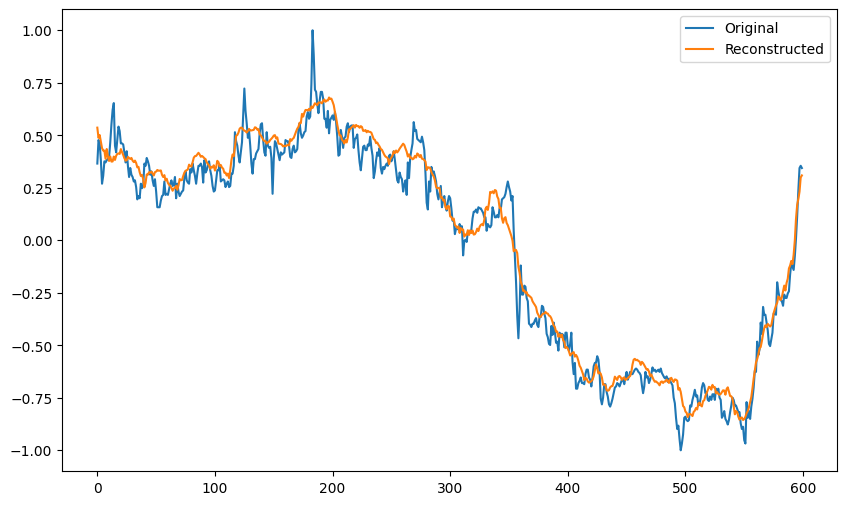

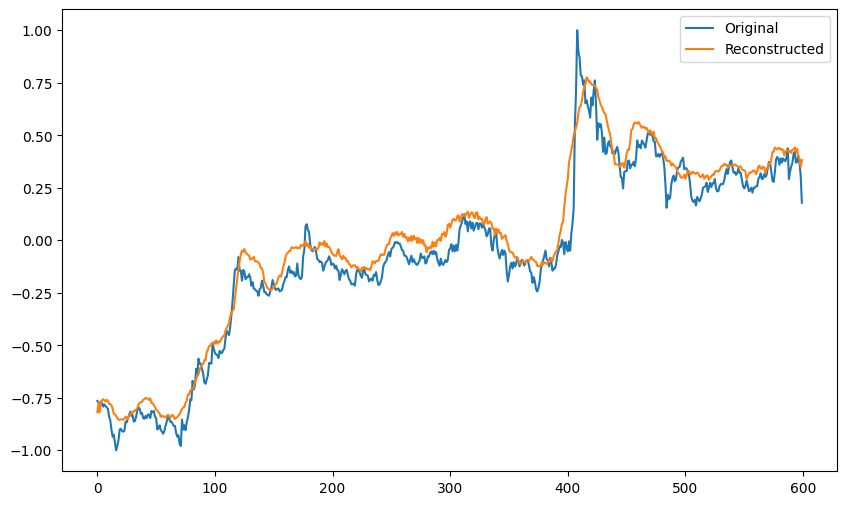

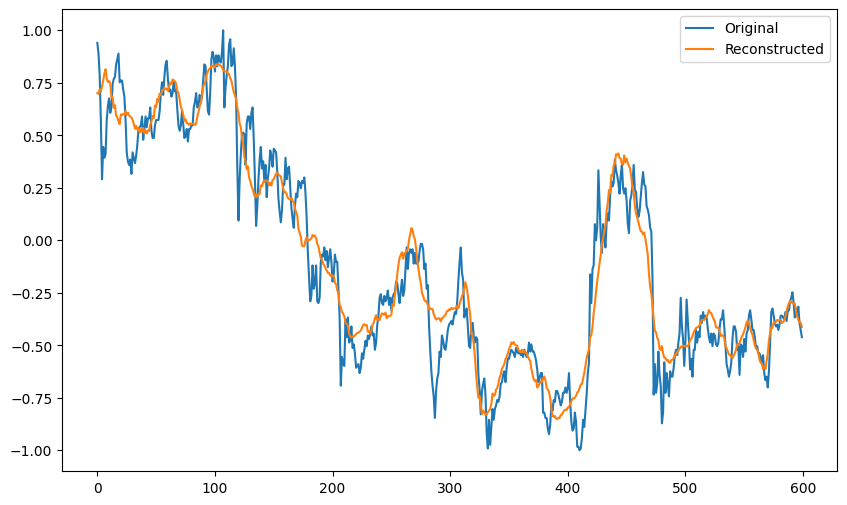

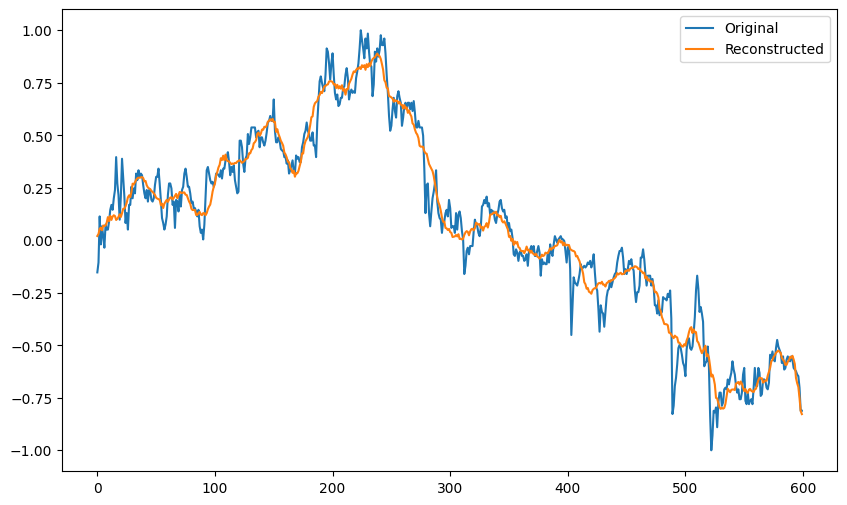

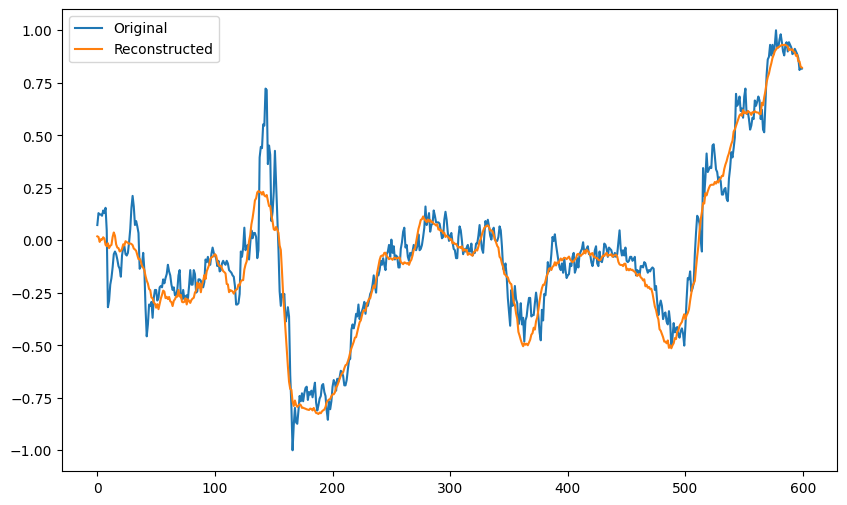

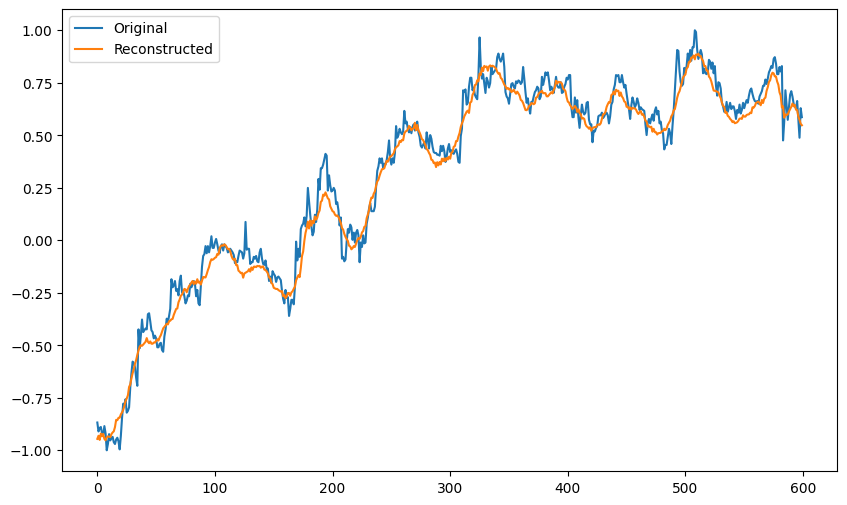

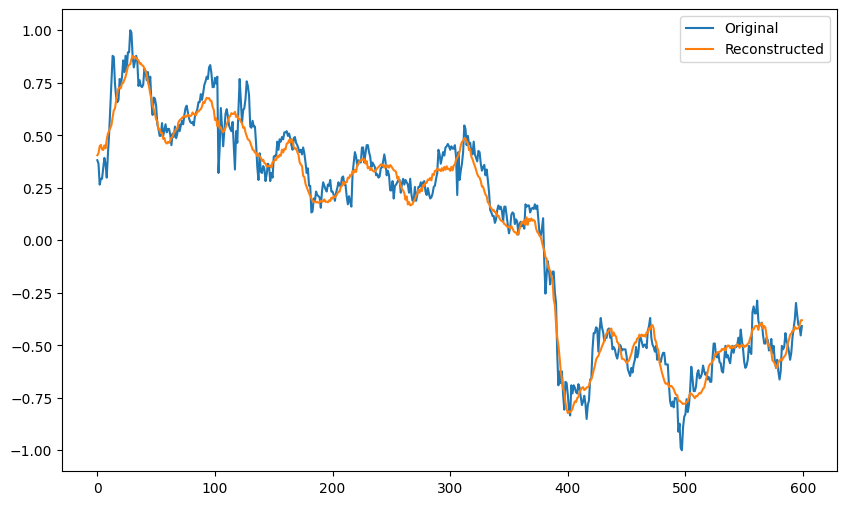

In [138]:
# Instantiate the model
model = ConvAutoencoder(n_features).to(device)

# Load the state_dict
model.load_state_dict(torch.load('conv_autoencoder_with_features.pth'))

# Set the model to evaluation mode
model.eval()


# Display reconstructed signals
def plot_signals(original, reconstructed, idx=0):
    plt.figure(figsize=(10, 6))
    plt.plot(original[idx].transpose(0, 1).cpu().numpy()[:, 0], label='Original')
    plt.plot(reconstructed[idx].transpose(0, 1).cpu().detach().numpy()[:, 0], label='Reconstructed')
    plt.legend()
    plt.show()

# Take a batch from validation set
example_data = next(iter(val_loader))[0].permute(0, 2, 1).to(device)
reconstructed_data = model(example_data)

for i in range(8, 15):
    plot_signals(example_data, reconstructed_data, idx=i)



In [140]:
import gym
from numpy import exp, argmax, random

import numpy as np
from sklearn import preprocessing


maker_fee = 0.01 * 0.01
taker_fee = 0.06 * 0.01
MAX_LEVERAGE = 25
fee_rate = 0.02 * 0.01
max_total_loss = 0.05
min_e = 0.2 * 0.01
LEVERAGE = 2

window = 600  # 200
t0 = window  # 200
tick_size = 0.0001
sample_size = 1200  # 800
th = 0.4

#import plot
class Status:
    def __init__(self):
        self.sum_scores = 0
        self.number_of_episodes = 0
        self.winning_days = 0
        self.visualize = False


global trade_envd
trade_envd = Status()




class TradeEnv(gym.Env):
    def __init__(self, data):
        super().__init__()
        # self.action_space = np.array(['buy', 'sell', 'close_long', 'close_short'])
        self.symbols = list(data.keys())
        self.symbol = random.choice(self.symbols)
        self.action_space = gym.spaces.Discrete(5)
        self.observation_space = gym.spaces.Box(-np.inf, np.inf, dtype=np.float32, shape=(window, 5))
        self.time = t0
        self.trading = False
        self.profit = 0
        self.order_list = []
        self.data = data
        n = random.randint(200, len(data[self.symbol]) - sample_size)
        self.sample = data[self.symbol][n: n + sample_size].copy()
        scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(self.sample[1 - window + self.time:self.time + 1, :-1])
        self.samplen = np.hstack([self.sample[:, :-1], self.sample[:, -1:]])
        self.state = self.samplen[1 - window + self.time:self.time + 1]
        self.state_size = window * 5
        self.score = 0
        self.num_trades = 0
        self.profit_t = 0
        self.profit_t1 = 0
        self.terminate = False
        self.day = int(n / 12 / 24)
        self.wins = 0
        self.filter = False

    def reset(self):
        # self.action_space = np.array(['buy', 'sell', 'close_long', 'close_short', 'd_target', 'd_stop_loss'])
        # self.action_space = np.array(['hold', 'buy', 'sell'])
        self.symbol = random.choice(self.symbols)
        self.time = t0
        self.trading = False
        self.profit = 0
        self.order_list = []
        n = random.randint(200, len(self.data[self.symbol]) - sample_size)
        self.sample = self.data[self.symbol][n: n + sample_size].copy()
        scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(self.sample[1 - window + self.time:self.time + 1, :-1])
        self.samplen = np.hstack(
            [self.sample[:, :-1], self.sample[:, -1:]])
        self.state = self.samplen[1 - window + self.time:self.time + 1]
        self.score = 0
        self.num_trades = 0
        self.profit_t = 0
        self.profit_t1 = 0
        self.terminate = False
        self.day = int(n / 12 / 24)
        self.wins = 0
        self.filter = False

        return self.state

    def step(self, action):
        global trade_envd
        global filter
        # [hold buy sell close_long close_short]
        close = self.sample[self.time, 0]
        ma = self.sample[self.time, 3]
        side = 0
        if action == 1:
            side = 1
        elif action == 2:
            side = -1

        e_target, e_stop_loss = 10, max_total_loss

        if not self.trading and not self.terminate:
            self.filter = False
            if side != 0 and self.check_params(side, e_target, e_stop_loss, self.time):
                #if not (close - ma)*side > 0:
                #    self.filter = True
                self.trading = True
                self.num_trades += 1
            reward = 0
        else:
            order = self.order_list[-1]
            order.exit_price = self.sample[self.time][0]
            if (order.side == 1 and action == 3) or (order.side == -1 and action == 4):
                order = self.close_order(order)
            else:
                order = self.check_limits(self.time, order)

            self.profit_t1 = self.profit_t
            self.profit_t = order.calculate_profit()
            d_profit = np.log(max(1 + self.profit_t, 1E-10)) \
                       - np.log(max(1 + self.profit_t1, 1E-10))
            #reward = d_profit * clip(np.sign(d_profit) * (exp(self.score) - 1))
            reward = d_profit
            #if self.filter:
            #    reward = 0
            self.score += reward

            if order.closed:
                # reward += 0.01 * np.sign(order.profit)
                if order.profit > 0:
                    self.wins += 1
            # if exp(self.score) < 0.7:
            #    self.terminate = True
            #    reward -= 0.8

        self.time += 1
        if self.trading:
            order = self.order_list[-1]
            # (close - entry) / (entry - stop_loss)
            self.sample[self.time, -1] = \
                (self.sample[self.time, 0] - order.entry_price) / (order.entry_price - order.stop_loss)
        
        self.state = self.samplen[1 - window + self.time:self.time + 1]
        self.state[:, :4] = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(self.state[:, :4])

        done = False
        if self.time >= sample_size - 1:
            if self.trading:
                order = self.order_list[-1]
                order.exit_price = self.sample[self.time][0]
                order = self.close_order(order)

                if order.profit > 0:
                    self.wins += 1
                    # reward += 0.01

                # self.profit_t1 = self.profit_t
                # self.profit_t = order.calculate_profit()
                # reward = np.log(1 + self.profit_t) - np.log(1 + self.profit_t1)
            # self.show_orders()
            trade_envd.number_of_episodes += 1
            trade_envd.sum_scores += self.score
            win_rate = None
            if len(self.order_list) > 0:
                win_rate = self.wins / len(self.order_list)
            if self.score > 0:
                trade_envd.winning_days += 1
            print(f"number of trades: {len(self.order_list)}, score: {exp(self.score) - 1}, win rate: {win_rate}"
                  f", profit: {calculate_total_profit(self.order_list)}, {self.symbol}, {self.day}")
            if len(self.order_list) <= 1:
                reward -= 0.5
            done = True
            if trade_envd.visualize:
                self.visualize()
        info = {}
        # print(self.state)
        # reward = np.log(max(1 + reward, 0.1))
        # reward -= 10 * self.num_trades / self.time
        #print(preprocessing.normalize(self.state[:, :-1]))
        return self.state, reward, done, info

    def close_order(self, order):
        close = self.sample[self.time][0]
        order.exit_price = close
        self.trading = False
        order.calculate_profit()
        order.duration = self.time - order.start_time
        order.end_time = self.time
        order.closed = True
        # print('profit:', order.profit)
        return order

    def check_limits(self, time, order):
        close = self.sample[time][0]
        high = self.sample[time][1]
        low = self.sample[time][2]
        entry = order.entry_price

        stop_loss = order.stop_loss
        target = order.target
        side = order.side

        if side == 1:
            rr = (high - entry) / (entry - stop_loss)
        else:
            rr = (low - entry) / (entry - stop_loss)

        if rr > order.max_rr:
            order.max_rr = rr

        if side * (close - stop_loss) <= 0:
            order.exit_price = order.stop_loss
            self.trading = False
            order.calculate_profit()
            order.closed = True
            order.duration = time - order.start_time
            order.end_time = self.time
            # print('profit:',order.profit)
        elif side * (close - target) >= 0:
            i = order.targets.index(target)
            # if i == len(order.targets) - 1:
            order.exit_price = order.target
            self.trading = False
            order.calculate_profit()
            order.closed = True
            order.duration = time - order.start_time
            order.end_time = self.time
            # print('profit:', order.profit)
            return order

            """
            else:
                order.target = order.targets[i + 1]
                order.stop_loss = order.stop_losses[i + 1]
            """

        return order

    def close(self):
        return

    def check_params(self, side, e_target, e_stop_loss, time):
        close = self.sample[time][0]
        target = close * (1 + side * e_target)
        stop_loss = close * (1 - side * min(max_total_loss, e_stop_loss))
        rr = (target - close) / (close - stop_loss)
        if stop_loss < 0:
            stop_loss = 0
        if target < 0:
            target = 0
        e = -(stop_loss / close - 1)
        # leverage = round(max_total_loss / (abs(e) + fee_rate * (abs(e) + 2)), 0)
        leverage = LEVERAGE
        if leverage > MAX_LEVERAGE:
            leverage = MAX_LEVERAGE
        elif leverage <= 1:
            leverage = 1
            # return False
        # if rr > 7:
        #  return False
        if abs(e) >= min_e and leverage >= 1 and abs(close - stop_loss) > 2 * tick_size:
            entry_price = close
            order = Order(e, 0, self.symbol, target, entry_price, stop_loss, side, None)
            order.leverage = leverage
            order.rr = rr
            order.targets, order.stop_losses = [target], [stop_loss]
            order.start_time = time
            self.order_list.append(order)
            self.profit_t1 = 0
            self.profit_t = 0
            # order.index = ohlc.index[time]
            # print('e:', order.e)
            # print('leverage:', order.leverage)
            return True
        else:
            return False

    def show_orders(self):
        print('   e    | side |exit rr |leverage|  fee   | profit |   duration  |  max rr   ')
        for order in self.order_list:
            a = [round(order.e, 4), round(order.side, 4), round(order.exit_rr, 4), order.leverage,
                 round(order.fee, 4),
                 round(order.profit, 4), round(order.duration, 4), round(order.max_rr, 4)]

            for x in a:
                print(str(x) + str_n(' ', 8 - len(str(x))) + '|', end="")
            print()

    def visualize(self):
        plot.show_chart(self.sample, self.symbol, self.order_list)


class Order:
    list = []

    def __init__(self, e, max_rr, symbol, target, entry_price, stop_loss, side, time):
        # self.entry = entry
        self.e = e
        self.leverage = 0
        self.max_rr = max_rr
        self.exit_rr = 0
        self.profit = 0
        self.entry_fee_rate = taker_fee
        self.exit_fee_rate = taker_fee
        self.fee = 0
        self.duration = 0

        self.symbol = symbol
        self.target = target
        self.entry_price = entry_price
        self.stop_loss = stop_loss
        self.stop_losses = [stop_loss]
        self.side = side
        self.time = time
        self.exit_price = 0
        self.lost = False
        self.won = False
        self.closed = False

    def calculate_leverage(self):
        leverage = round(
            max_total_loss / (abs(self.e) + self.entry_fee_rate + self.exit_fee_rate * (1 + self.e)), 0)
        if leverage > MAX_LEVERAGE:
            leverage = MAX_LEVERAGE
        self.leverage = leverage

    def calculate_profit(self):

        if self.entry_price == 0:
            self.calculate_leverage()
            rr = 0
            if self.max_rr >= rr and self.max_rr >= 1:
                self.exit_rr = rr
                self.exit_fee_rate = maker_fee
            elif self.max_rr >= 1:
                self.exit_rr = 0.2
                self.exit_fee_rate = taker_fee

            # elif self.max_rr >= 0.5:
            #    self.exit_rr = 0.1
            #    self.exit_fee_rate = taker_fee
            else:
                self.exit_rr = -1
                self.exit_fee_rate = taker_fee
        else:
            self.exit_rr = (self.exit_price - self.entry_price) / (self.entry_price - self.stop_losses[0])

        # if self.exit_rr >= self.exit_rr * 0.95:
        #    self.exit_fee_rate = maker_fee
        self.exit_fee_rate = taker_fee

        self.profit = self.leverage * (self.exit_rr * abs(self.e)) - self.calculate_fee()
        return self.profit

    def calculate_fee(self):
        # F = lf (2 + e)  F = l ( f1 + f2(1+e) )
        self.fee = self.leverage * (self.entry_fee_rate + self.exit_fee_rate * (1 + self.e))
        return self.fee


def calculate_total_profit(order_list):
    profit = 1
    for order in order_list:
        profit *= (1 + order.profit)

    return profit - 1


def str_n(ch, n):
    st = ""
    for i in range(n):
        st += ch
    return st


def tanh(x):
    t = (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
    return t


def softmax(vector):
    e = exp(vector)
    return e / e.sum()

def smoothclamp(x, mi, mx):
    return 1-(mi + (mx-mi)*(lambda t: np.where(t < 0 , 0, np.where( t <= 1 , 3*t**2-2*t**3, 1 ) ) )( (x-mi)/(mx-mi) ))


def clip(x):
    return smoothclamp(1.5*(x-0.4), 0, 1) # 4.5, 0.4


In [ ]:
# docs and experiment results can be found at https://docs.cleanrl.dev/rl-algorithms/ppo/#ppo_ataripy
import argparse
import os
import random
import time
from collections import namedtuple
from distutils.util import strtobool

import gym
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical
from torch.utils.tensorboard import SummaryWriter


from gym import wrappers
from tednet.tnn import tensor_train
import tednet.tnn.tensor_ring as tr
#global data
from tednet.tnn.tensor_ring import TRConv2D
import pandas_ta as ta
#from torchvision.models import efficientnet_b7
#from efficientnet_pytorch import EfficientNet
#import timm



load = False
num_envs = 20


def parse_args():
    # fmt: off
    parser = argparse.ArgumentParser()

    parser.add_argument("--exp-name", type=str, default="PPO_Eff",
        help="the name of this experiment")
    parser.add_argument("--seed", type=int, default=1,
        help="seed of the experiment")
    parser.add_argument("--torch-deterministic", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="if toggled, `torch.backends.cudnn.deterministic=False`")
    parser.add_argument("--cuda", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="if toggled, cuda will be enabled by default")
    parser.add_argument("--track", type=lambda x: bool(strtobool(x)), default=False, nargs="?", const=True,
        help="if toggled, this experiment will be tracked with Weights and Biases")
    parser.add_argument("--wandb-project-name", type=str, default="cleanRL",
        help="the wandb's project name")
    parser.add_argument("--wandb-entity", type=str, default=None,
        help="the entity (team) of wandb's project")
    parser.add_argument("--capture-video", type=lambda x: bool(strtobool(x)), default=False, nargs="?", const=True,
        help="whether to capture videos of the agent performances (check out `videos` folder)")

    # Algorithm specific arguments
    parser.add_argument("--env-id", type=str, default="BreakoutNoFrameskip-v4",
        help="the id of the environment")
    parser.add_argument("--total-timesteps", type=int, default=1000000000,
        help="total timesteps of the experiments")
    parser.add_argument("--learning-rate", type=float, default=2.5e-4,
        help="the learning rate of the optimizer")
    parser.add_argument("--num-envs", type=int, default=num_envs,
        help="the number of parallel game environments")
    parser.add_argument("--num-steps", type=int, default=600,
        help="the number of steps to run in each environment per policy rollout")
    parser.add_argument("--anneal-lr", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="Toggle learning rate annealing for policy and value networks")
    parser.add_argument("--gamma", type=float, default=0.99,
        help="the discount factor gamma")
    parser.add_argument("--gae-lambda", type=float, default=0.95,
        help="the lambda for the general advantage estimation")
    parser.add_argument("--num-minibatches", type=int, default=4,
        help="the number of mini-batches")
    parser.add_argument("--update-epochs", type=int, default=4,
        help="the K epochs to update the policy")
    parser.add_argument("--norm-adv", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="Toggles advantages normalization")
    parser.add_argument("--clip-coef", type=float, default=0.1,#0.1
        help="the surrogate clipping coefficient")
    parser.add_argument("--clip-vloss", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="Toggles whether or not to use a clipped loss for the value function, as per the paper.")
    parser.add_argument("--ent-coef", type=float, default=0.01,
        help="coefficient of the entropy")
    parser.add_argument("--vf-coef", type=float, default=0.5,
        help="coefficient of the value function")
    parser.add_argument("--max-grad-norm", type=float, default=0.5,
        help="the maximum norm for the gradient clipping")
    parser.add_argument("--target-kl", type=float, default=None,
        help="the target KL divergence threshold")

    args = parser.parse_args(args=[])
    print("***************")
    args.batch_size = int(args.num_envs * args.num_steps)
    args.minibatch_size = int(args.batch_size // args.num_minibatches)
    # fmt: on
    return args


def make_env(data_train, env_id, idx, run_name):
    def thunk():
        #env = gym.make(env_id)
        env = TradeEnv(data_train)
        env = gym.wrappers.RecordEpisodeStatistics(env)

        #env = NoopResetEnv(env, noop_max=30)
        #env = MaxAndSkipEnv(env, skip=4)
        #env = EpisodicLifeEnv(env)
        #if "FIRE" in env.unwrapped.get_action_meanings():
        #    env = FireResetEnv(env)
        #env = ClipRewardEnv(env)
        #env = gym.wrappers.ResizeObservation(env, (84, 84))
        #env = gym.wrappers.GrayScaleObservation(env)
        #env = gym.wrappers.FrameStack(env, 1)
        #env.seed(seed)
        #env.action_space.seed(seed)
        #env.observation_space.seed(seed)
        return env

    return thunk


def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer


class SelfAttentionLayer(nn.Module):
    def __init__(self, feature_size):
        super(SelfAttentionLayer, self).__init__()
        self.feature_size = feature_size

        # Linear transformations for Q, K, V from the same source
        self.key = nn.Linear(feature_size, feature_size)
        self.query = nn.Linear(feature_size, feature_size)
        self.value = nn.Linear(feature_size, feature_size)

    def forward(self, x, mask=None):
        # Apply linear transformations
        keys = self.key(x)
        queries = self.query(x)
        values = self.value(x)

        # Scaled dot-product attention
        scores = torch.matmul(queries, keys.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.feature_size, dtype=torch.float32))

        # Apply mask (if provided)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # Apply softmax
        attention_weights = F.softmax(scores, dim=-1)

        # Multiply weights with values
        output = torch.matmul(attention_weights, values)

        return output, attention_weights


class Agent(nn.Module):
    def __init__(self):
        super(Agent, self).__init__()
        
        num_actions = 5  # Number of possible actions
        input_dim = 5  # Number of channels
        hidden_dim = 128
        in_channels = 5
        """
        self.network = ResAtt(in_channels, hidden_dim, block=ResNetBasicBlock, deepths=[2, 2, 2]).to(device)
        
        self.actor = nn.Sequential(
            layer_init(nn.Linear(hidden_dim, num_actions), std=0.01)
        )
        self.critic = nn.Sequential(
            layer_init(nn.Linear(hidden_dim, 1), std=0.01)
        )
        
        pytorch_total_params = sum(p.numel() for p in self.parameters())
        pytorch_total_param = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(pytorch_total_params, pytorch_total_param)

    def forward(self, x):
        #idx = [0, 1, 2, 4]
        #x = x[:, :, idx]
        x = torch.transpose(x, 1, 2)
        x = self.network(x)

        return x
        
        """
        # Instantiate the model
        self.n_features = 60
        auto_encoder = ConvAutoencoder(self.n_features)

        # Load the state_dict
        auto_encoder.load_state_dict(torch.load('conv_autoencoder_with_features.pth'))

        # Set the model to evaluation mode
        #auto_encoder.eval()
        
        self.encoder = model.encoder
        
        for param in self.encoder.parameters():
            param.requires_grad = False  # Freeze the encoder
        
        self.n_input = self.n_features + 1 + 30

        self.lin = nn.Sequential(
            
            layer_init(nn.Linear(self.n_input, 128)),
            nn.ReLU(),
            
            tensor_train.TTLinear([4, 4, 4, 2], [4, 4, 4, 2], [8, 8, 8]),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            #nn.Dropout(p=0.2),
            tensor_train.TTLinear([4, 4, 4, 2], [4, 4, 4, 2], [8, 8, 8]),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
        )
        hidden_dim = 128
        self.actor = nn.Sequential(
            layer_init(nn.Linear(hidden_dim, num_actions), std=0.01)
        )
        self.critic = nn.Sequential(
            layer_init(nn.Linear(hidden_dim, 1), std=0.01)
        )

    def forward(self, x):
        profit = x[:, -1, -1].unsqueeze(1)
        close_5 = torch.flatten(x[:, -10:, :3], start_dim=1)
       # plt.plot(x[0, :, :3].cpu())
       # plt.show()
        #import time

       # time.sleep(500)
        x = x[:, :, :3]
        #print( torch.min(x),  torch.max(x))
        x = self.encoder(torch.transpose(x, 1, 2))

        x = torch.cat((x, close_5, profit), dim=1)
        x = self.lin(x)
        
        return x
    
        

    def get_value(self, x):
        return self.critic(self.forward(x))

    def get_action_and_value(self, x, action=None):
        hidden = self.forward(x)
        logits = self.actor(hidden)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.critic(hidden)




def pre_process(ohlc):
    ma1_period = 600
    ma2_period = 200

    ohlc['ma1'] = ta.ema(ohlc['close'], length=ma1_period)
    ohlc['ma2'] = ta.ema(ohlc['close'], length=ma2_period)
    ohlc = ohlc[ma1_period + 1:]
    ohlc['distance'] = np.zeros(len(ohlc))
    data = np.vstack((ohlc['close'], ohlc['high'], ohlc['low'],
                              ohlc['ma1'], ohlc['distance'])).T
    return data


if __name__ == "__main__":
    symbols = ['TSLA', 'AAPL', 'MSFT', 'AMZN']#, 'AMD', 'TMUS']
    symbols = ['ADA', 'ETH','LTC','BNB','SOL', 'MATIC']
              #'ARB','MATIC','APT','SUI','SAND','RNDR','TRX','AVAX']
    data_train = {}
    data_val = {}
    for symbol in symbols:
        #ohlc_test = data_download.download_symbol(symbol, 5, 365*2+6*30)
        ohlc = pd.read_csv('data/'+ symbol +'/2023-02-14'+"_" + str(5)+'.csv')
        data = pre_process(ohlc)
        data_train[symbol] = data[:-int(len(data)/6)]
        data_val[symbol] = data[-int(len(data) / 6):]
        print(len(data_val))

        #print(len(ohlc))



    # ohlc = ohlc[:int(len(ohlc)*0.8)]


    args = parse_args()

    run_name = f"{args.env_id}__{args.exp_name}__{args.seed}__{int(time.time())}"
    if args.track:
        import wandb

        wandb.init(
            project=args.wandb_project_name,
            entity=args.wandb_entity,
            sync_tensorboard=True,
            config=vars(args),
            name=run_name,
            monitor_gym=True,
            save_code=True,
        )
    writer = SummaryWriter(f"runs/{run_name}")
    writer.add_text(
        "hyperparameters",
        "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
    )


    # TRY NOT TO MODIFY: seeding
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = args.torch_deterministic

    device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

    # env setup
    print(args)
    
    envs = gym.vector.SyncVectorEnv(
        [make_env(data_train, args.env_id, i, run_name) for i in range(args.num_envs)])
    envs_val = gym.vector.SyncVectorEnv(
        [make_env(data_val, args.env_id, i, run_name) for i in
         range(args.num_envs)]
    )
    assert isinstance(envs.single_action_space, gym.spaces.Discrete), "only discrete action space is supported"

    agent = Agent().to(device)
    optimizer = optim.Adam(agent.parameters(), eps=1e-5, lr=args.learning_rate)#, eps=1e-5
    #optimizer = torch.optim.SGD(agent.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-8)

    # ALGO Logic: Storage setup
    obs = torch.zeros((args.num_steps, args.num_envs) + envs.single_observation_space.shape).to(device)
    actions = torch.zeros((args.num_steps, args.num_envs) + envs.single_action_space.shape).to(device)
    logprobs = torch.zeros((args.num_steps, args.num_envs)).to(device)
    rewards = torch.zeros((args.num_steps, args.num_envs)).to(device)
    dones = torch.zeros((args.num_steps, args.num_envs)).to(device)
    values = torch.zeros((args.num_steps, args.num_envs)).to(device)

    # TRY NOT TO MODIFY: start the game
    global_step = 0
    start_time = time.time()
    next_obs = torch.Tensor(envs.reset()).to(device)
    next_done = torch.zeros(args.num_envs).to(device)
    num_updates = args.total_timesteps // args.batch_size

    m = 0
    best = 0.06
    model_path = "/kaggle/working/"
    load_path = model_path
    save_path = model_path
    if load:
        #device = torch.device('cuda:0')#cuda:0
        st = ""
        #st = "_best"
        agent.actor = torch.load(load_path + "_actor" + st + ".pt", map_location=device)
        agent.critic = torch.load(load_path + "_critic" + st + ".pt", map_location=device)

    for update in range(1, num_updates + 1):
        # Annealing the rate if instructed to do so.
        if args.anneal_lr:
            frac = 1.0 - (update - 1.0) / num_updates
            lrnow = frac * args.learning_rate
            optimizer.param_groups[0]["lr"] = lrnow
        
        for phase in ['val', 'train']:
            #if phase == 'train':
            #    agent.train()
            #else:
            #    agent.eval()
                
            for step in range(0, args.num_steps):
                global_step += 1 * args.num_envs
                obs[step] = next_obs
                dones[step] = next_done

                # ALGO LOGIC: action logic
                with torch.no_grad():
                    action, logprob, _, value = agent.get_action_and_value(next_obs)
                    values[step] = value.flatten()
                actions[step] = action
                logprobs[step] = logprob

                # TRY NOT TO MODIFY: execute the game and log data.
                if phase == 'train':
                    next_obs, reward, done, info = envs.step(action.cpu().numpy())
                else:
                    next_obs, reward, done, info = envs_val.step(action.cpu().numpy())
                rewards[step] = torch.tensor(reward).to(device).view(-1)
                next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(done).to(device)

                for item in info:
                    if "episode" in item.keys():
                        print(f"global_step={global_step}, episodic_return={item['episode']['r']}")
                        writer.add_scalar("charts/episodic_return", item["episode"]["r"], global_step)
                        writer.add_scalar("charts/episodic_length", item["episode"]["l"], global_step)
                        break

            if trade_envd.number_of_episodes!=0:
                mean_score = (np.exp(trade_envd.sum_scores / trade_envd.number_of_episodes) - 1)
                winning_days_rate = trade_envd.winning_days / trade_envd.number_of_episodes
                print(phase + " mean score: ", mean_score)
                print(phase + " winning days rate: ", winning_days_rate)

                if mean_score >= best and winning_days_rate >= 0.6:
                    best = mean_score
                    torch.save(agent.critic, save_path + "_critic_best.pt")
                    torch.save(agent.actor, save_path + "_actor_best.pt")


            trade_envd.sum_scores = 0
            trade_envd.number_of_episodes = 0
            trade_envd.winning_days = 0


        # bootstrap value if not done
        with torch.no_grad():
            next_value = agent.get_value(next_obs).reshape(1, -1)
            advantages = torch.zeros_like(rewards).to(device)
            lastgaelam = 0
            for t in reversed(range(args.num_steps)):
                if t == args.num_steps - 1:
                    nextnonterminal = 1.0 - next_done
                    nextvalues = next_value
                else:
                    nextnonterminal = 1.0 - dones[t + 1]
                    nextvalues = values[t + 1]
                delta = rewards[t] + args.gamma * nextvalues * nextnonterminal - values[t]
                advantages[t] = lastgaelam = delta + args.gamma * args.gae_lambda * nextnonterminal * lastgaelam
            returns = advantages + values

        # flatten the batch
        b_obs = obs.reshape((-1,) + envs.single_observation_space.shape)
        b_logprobs = logprobs.reshape(-1)
        b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
        b_advantages = advantages.reshape(-1)
        b_returns = returns.reshape(-1)
        b_values = values.reshape(-1)

        # Optimizing the policy and value network
        b_inds = np.arange(args.batch_size)
        clipfracs = []
        for epoch in range(args.update_epochs):
            np.random.shuffle(b_inds)
            for start in range(0, args.batch_size, args.minibatch_size):
                end = start + args.minibatch_size
                mb_inds = b_inds[start:end]

                _, newlogprob, entropy, newvalue = agent.get_action_and_value(b_obs[mb_inds], b_actions.long()[mb_inds])
                logratio = newlogprob - b_logprobs[mb_inds]
                ratio = logratio.exp()

                with torch.no_grad():
                    # calculate approx_kl http://joschu.net/blog/kl-approx.html
                    old_approx_kl = (-logratio).mean()
                    approx_kl = ((ratio - 1) - logratio).mean()
                    clipfracs += [((ratio - 1.0).abs() > args.clip_coef).float().mean().item()]

                mb_advantages = b_advantages[mb_inds]
                if args.norm_adv:
                    mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

                # Policy loss
                pg_loss1 = -mb_advantages * ratio
                pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - args.clip_coef, 1 + args.clip_coef)
                pg_loss = torch.max(pg_loss1, pg_loss2).mean()

                # Value loss
                newvalue = newvalue.view(-1)
                if args.clip_vloss:
                    v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                    v_clipped = b_values[mb_inds] + torch.clamp(
                        newvalue - b_values[mb_inds],
                        -args.clip_coef,
                        args.clip_coef,
                    )
                    v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                    v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                    v_loss = 0.5 * v_loss_max.mean()
                else:
                    v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

                entropy_loss = entropy.mean()
                loss = pg_loss - args.ent_coef * entropy_loss + v_loss * args.vf_coef

                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(agent.parameters(), args.max_grad_norm)
                optimizer.step()

            if args.target_kl is not None:
                if approx_kl > args.target_kl:
                    break

        y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
        var_y = np.var(y_true)
        explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

        # TRY NOT TO MODIFY: record rewards for plotting purposes
        writer.add_scalar("charts/learning_rate", optimizer.param_groups[0]["lr"], global_step)
        writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
        writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
        writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
        writer.add_scalar("losses/old_approx_kl", old_approx_kl.item(), global_step)
        writer.add_scalar("losses/approx_kl", approx_kl.item(), global_step)
        writer.add_scalar("losses/clipfrac", np.mean(clipfracs), global_step)
        writer.add_scalar("losses/explained_variance", explained_var, global_step)
        print("SPS:", int(global_step / (time.time() - start_time)))
        writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)

        m += 1
        if m >= 30:
            m = 0

            torch.save(agent.critic, save_path + "_critic.pt")
            torch.save(agent.actor, save_path + "_actor.pt")

            # model = torch.jit.load('model_scripted.pt')
            # model.eval()
            print("************       SAVING         ************")

    envs.close()
    writer.close()

In [126]:

import torch
import torch.nn as nn

from functools import partial


# self attention mechanism
class SelfAttentionBlock(nn.Module):
    """
        Implementation of Self attention Block according to paper
        Self-Attention Generative Adversarial Networks (https://arxiv.org/abs/1805.08318)
    """

    def __init__(self, in_feature_maps):
        super(SelfAttentionBlock, self).__init__()

        self.in_feature_maps = in_feature_maps
        # get query(f), key(g), value(h) weights matrices
        self.conv_f = nn.Conv1d(in_channels=in_feature_maps, out_channels=in_feature_maps // 8, kernel_size=1,
                                padding=0)
        self.conv_g = nn.Conv1d(in_channels=in_feature_maps, out_channels=in_feature_maps // 8, kernel_size=1,
                                padding=0)
        self.conv_h = nn.Conv1d(in_channels=in_feature_maps, out_channels=in_feature_maps, kernel_size=1, padding=0)

        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input):
        batch_size, C, width = input.size()
        N = width
        x = input.view(batch_size, -1, N)

        # get query(f), key(g), value(h) matrices
        f = self.conv_f(x)
        g = self.conv_g(x)
        h = self.conv_h(x)

        # calculates the attention score
        s = torch.bmm(f.permute(0, 2, 1), g)
        beta = self.softmax(s)
        o = torch.bmm(h, beta)
        o = o.view((batch_size, C, width))

        return self.gamma * o + input


"""
    Modified from Implementing ResNet in Pytorch
    Author: Francesco Saverio Zuppichini
    License: https://github.com/FrancescoSaverioZuppichini/ResNet/blob/master/LICENSE
    Code URL: https://github.com/FrancescoSaverioZuppichini/ResNet/blob/master/ResNet.ipynb
"""


class Conv1dAuto(nn.Conv1d):
    # basic convolutional layer
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding = (
            self.kernel_size[0] // 2)  # dynamic add padding based on the kernel_size


conv3x3 = partial(Conv1dAuto, kernel_size=3, bias=False)


class ResidualBlock(nn.Module):
    # build a residual block that has basic information of shortcut and convolutional layer
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels, self.out_channels = in_channels, out_channels
        self.blocks = nn.Identity()
        self.shortcut = nn.Identity()

    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x

    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels


class ResNetResidualBlock(ResidualBlock):
    # build ResNet Residual Block based on basic ResidualBlock function with assigning shortcut features - a convolutional layer followed by batch normalizaiton
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(OrderedDict(
            {
                'conv': nn.Conv1d(self.in_channels, self.expanded_channels, kernel_size=1,
                                  stride=self.downsampling, bias=False),
                'bn': nn.BatchNorm1d(self.expanded_channels)

            })) if self.should_apply_shortcut else None

    # expand dimensions
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion

    # to check whether the dimension changes between input and output so to decide whether applying expanded_channels
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels


from collections import OrderedDict


def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    # batch normalization
    return nn.Sequential(OrderedDict({'conv': conv(in_channels, out_channels, *args, **kwargs),
                                      'bn': nn.BatchNorm1d(out_channels)}))


class ResNetBasicBlock(ResNetResidualBlock):
    # Implemented ResNet Blocks that has 2 convolutional layers with the shortcut
    expansion = 1

    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation(),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )


class ResNetLayer(nn.Module):
    # ResNet Layer that stacks several residual blocks followed by a self-attention mechanism
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1

        self.blocks = nn.Sequential(
            block(in_channels, out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion,
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )
        #         add attention
        self.self_attention_block = SelfAttentionBlock(in_feature_maps=out_channels)

    def forward(self, x):
        x = self.blocks(x)
        #   add self-attention mechanism here
        x = self.self_attention_block(x)
        return x


class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by increasing different layers with increasing features.
    """

    # Implement the encoder part, which is the feature extraction part in the paper.
    def __init__(self, in_channels=3, blocks_sizes=[32, 64, 128], deepths=[2, 2, 2],
                 activation=nn.ReLU, block=ResNetBasicBlock, *args, **kwargs):
        super().__init__()

        self.blocks_sizes = blocks_sizes

        # At the beginning, connect the input features into the model
        self.gate = nn.Sequential(
            nn.Conv1d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(self.blocks_sizes[0]),
            activation(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )
        # get each block's block information - input/output dimensions
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))

        # stack all ResNet Layer to gain the structure of Feature Extractor
        self.blocks = nn.ModuleList([
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation,
                        block=block, *args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion,
                          out_channels, n=n, activation=activation,
                          block=block, *args, **kwargs)
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]
        ])

    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x


class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """

    # This is the classification part of my model
    def __init__(self, in_features, n_classes):
        super().__init__()
        # average pooling at first
        self.avg = nn.AdaptiveAvgPool1d(30)
        # set drop out and softmax function. also limit the output channel to 6, as the same as total species that we are classifying
        self.decoder = nn.Sequential(nn.Dropout(0.3),
                                     nn.Linear(in_features*30, n_classes),
                                     nn.ReLU())
                                     
                                     

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x


class ResAtt(nn.Module):
    # The ResNet-Attention (WbNet) model combines both encoder part (Feature Extractor) and decoder part (Classification).
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# define our ResNet-18 based model with self-attention mechanism - WbNet
def resnet18_attention(in_channels, n_classes):
    return ResAtt(in_channels, n_classes, block=ResNetBasicBlock, deepths=[2, 2, 2])



In [122]:
x = torch.rand(30, 4, 600)
model = ResAtt(4, 60, block=ResNetBasicBlock, deepths=[2, 2, 2])
y = model(x)
print(y.shape)

torch.Size([30, 60])
